# Semantic Clustering Using Word Embeddings (with Model Comparison)

This notebook demonstrates **semantic clustering** using **spaCy word embeddings**.  
We’ll explore how words with similar meanings can be grouped using **K-Means clustering**.  

Additionally, we’ll **compare two different spaCy models** — `en_core_web_md` and `en_core_web_lg` — to see which produces more meaningful clusters.

**Concepts covered:**
- Word embeddings and semantic similarity  
- K-Means clustering  
- Model comparison based on embedding quality  
- Visualization with PCA

## Import Libraries

In [1]:
import spacy
import subprocess
import sys
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt


## Step 1: Load a spaCy Embedding Model

In this activity, you’ll compare how **different spaCy embedding models** affect semantic clustering.

You can switch between:
- `en_core_web_md` → medium model (faster, smaller, less detailed)
- `en_core_web_lg` → large model (slower, more accurate, richer embeddings)

Change the model name in the code below to experiment with both and observe how the clusters differ.

In [9]:
# Choose which model to use ("en_core_web_md" or "en_core_web_lg")
MODEL_NAME = "en_core_web_md"

# Helper function to load or download the selected model
def load_spacy_model(name):
    try:
        return spacy.load(name)
    except OSError:
        print(f"Model '{name}' not found. Downloading...")
        subprocess.check_call([sys.executable, "-m", "spacy", "download", name])
        return spacy.load(name)

# Load the selected model
try:
    nlp = load_spacy_model(MODEL_NAME)
    print(f"Loaded model: {MODEL_NAME}")
except Exception as e:
    print(f"Could not load model '{MODEL_NAME}': {e}")
    sys.exit(1)

Loaded model: en_core_web_md


## Word List
We’ll use a mix of emotion, film, food, and technology-related words for semantic grouping.

In [10]:
words = [
    "happy", "joyful", "sad", "angry", "frustrated",
    "film", "movie", "cinema", "screenplay", "actor", "director",
    "good", "bad", "amazing", "boring", "exciting", "terrible",
    "love", "hate", "enjoy", "dislike",
    "computer", "keyboard", "mouse", "monitor", "laptop",
    "apple", "banana", "orange", "pizza", "burger", "sandwich",
    "run", "walk", "swim", "jump", "think", "believe", "analyze",
    "data", "model", "algorithm", "network"
]

## Step 2: Extract Word Embeddings

In this step, we use the selected **spaCy model** to convert each word into its **embedding vector** — a numerical representation that captures semantic meaning.

- Words with available vectors are stored in `valid_words`.
- Their corresponding numeric embeddings are stored in `embeddings`.

You may see warnings if some words don’t exist in the model’s vocabulary — that’s normal.  
After running this cell, check how many words were successfully represented by the model.

In [11]:
import numpy as np

# Extract embeddings for all words in the list
embeddings = []
valid_words = []

for word in words:
    doc = nlp(word)
    if doc.has_vector:
        embeddings.append(doc.vector)
        valid_words.append(word)
    else:
        print(f"Warning: '{word}' has no vector and will be skipped.")

# Convert to NumPy array
embeddings = np.array(embeddings)

print(f"Extracted embeddings for {len(valid_words)} words using model: {MODEL_NAME}")
print(f"Embedding dimension: {embeddings.shape[1]}")

Extracted embeddings for 43 words using model: en_core_web_md
Embedding dimension: 300


## Step 3: Cluster Words by Semantic Similarity

Now that we have embeddings, we can use **K-Means clustering** to group semantically similar words together.

- The number of clusters (`n_clusters`) is chosen automatically based on the size of the vocabulary (between 4 and 6).  
- Each cluster will contain words that have **similar meanings or contexts** according to their embedding vectors.  

After running this cell, review the printed clusters — do they make sense linguistically?  
You’ll compare the clustering results for different spaCy models later to see which captures meaning better.

In [13]:
# Determine an appropriate number of clusters based on vocabulary size
n_clusters = 4

# Run K-Means clustering on the word embeddings
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(embeddings)

# Display results
print("SEMANTIC CLUSTERING USING WORD EMBEDDINGS")
print(f"Model: {MODEL_NAME}")
print(f"Number of clusters: {n_clusters}\n")

# Print words grouped by cluster
for i in range(n_clusters):
    cluster_words = [valid_words[j] for j in range(len(valid_words)) if clusters[j] == i]
    if cluster_words:
        print(f"Cluster {i+1} ({len(cluster_words)} words): {cluster_words}")


SEMANTIC CLUSTERING USING WORD EMBEDDINGS
Model: en_core_web_md
Number of clusters: 4

Cluster 1 (7 words): ['director', 'computer', 'analyze', 'data', 'model', 'algorithm', 'network']
Cluster 2 (7 words): ['angry', 'frustrated', 'love', 'hate', 'dislike', 'think', 'believe']
Cluster 3 (6 words): ['apple', 'banana', 'orange', 'pizza', 'burger', 'sandwich']
Cluster 4 (23 words): ['happy', 'joyful', 'sad', 'film', 'movie', 'cinema', 'screenplay', 'actor', 'good', 'bad', 'amazing', 'boring', 'exciting', 'terrible', 'enjoy', 'keyboard', 'mouse', 'monitor', 'laptop', 'run', 'walk', 'swim', 'jump']


## Step 4: Visualize the Semantic Clusters

To better understand how words are grouped, we can visualize the high-dimensional embeddings in **2D space**.

We’ll use **PCA (Principal Component Analysis)** to reduce the embedding dimensions while preserving as much variance (information) as possible.  
Each color in the plot represents one cluster, and each point corresponds to a word.

After running this cell:
- Inspect how well similar words appear close together.
- Compare how different spaCy models (medium vs. large) change the clustering quality.

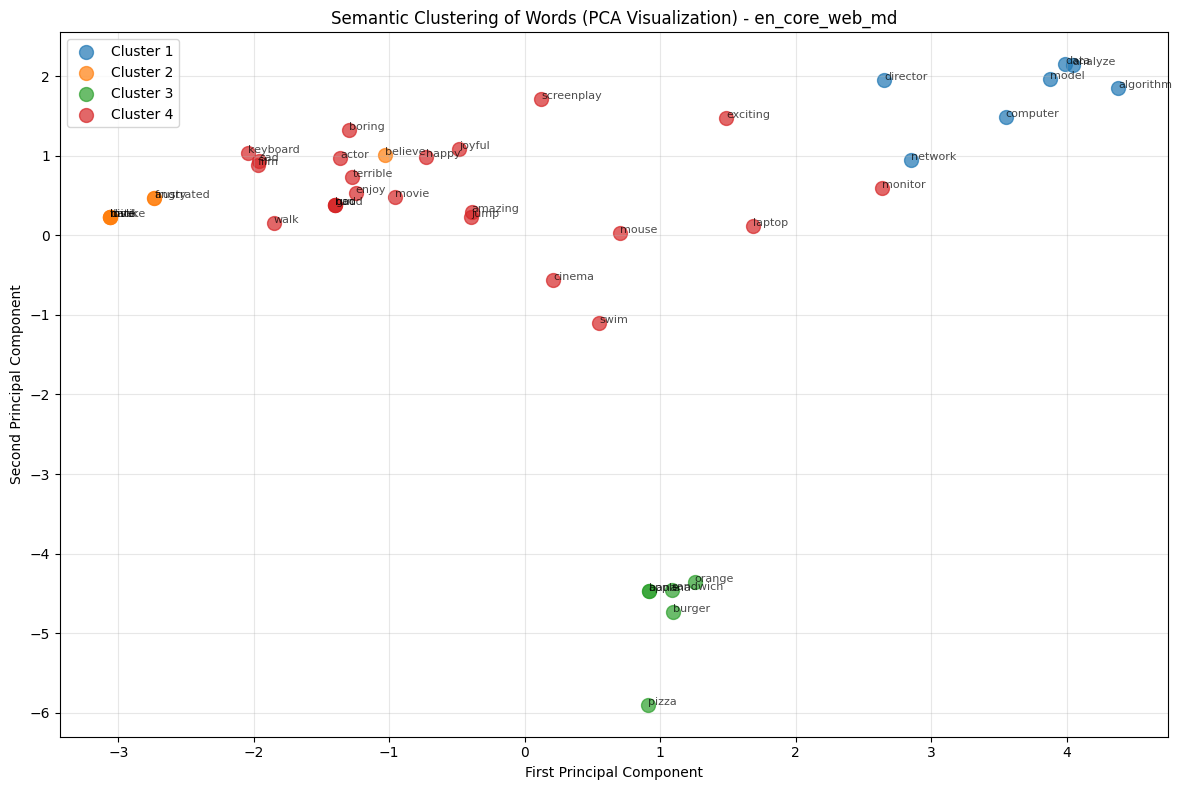


Visualization saved to 'semantic_clusters.png'


In [14]:
# Reduce embeddings to 2D using PCA for visualization
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings)

# Plot the clusters
plt.figure(figsize=(12, 8))
for i in range(n_clusters):
    cluster_mask = clusters == i
    plt.scatter(
        embeddings_2d[cluster_mask, 0],
        embeddings_2d[cluster_mask, 1],
        label=f'Cluster {i+1}',
        s=100,
        alpha=0.7
    )

# Add word labels
for i, word in enumerate(valid_words):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8, alpha=0.7)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title(f'Semantic Clustering of Words (PCA Visualization) - {MODEL_NAME}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save and show the visualization
plt.savefig('semantic_clusters.png', dpi=150)
plt.show()

print("\nVisualization saved to 'semantic_clusters.png'")


## Step 5: Model Comparison and Discussion

Now it’s time to **analyze and discuss your results**.

1. Review the clusters and visualizations you obtained from your experiment.  
2. Take note of specific observations, such as:  
   - Which groups of words make clear sense together?  
   - Which words seem misplaced or ambiguous?  
   - How well the model captures **semantic similarity** (e.g., *movie–film* vs. *cat–dog*).  
3. Record your findings and **share them in the Cascade discussion forums**, summarizing:  
   - What patterns or insights you noticed.  
   - How the clustering differed between models or configurations.  
   - Any unexpected or interesting outcomes.  

After that, **experiment further**:
- Try adjusting the number of clusters.  
- Change or expand your word list.  
- Compare results using different spaCy models (`en_core_web_md` vs. `en_core_web_lg`).  

Reflect on how these changes affect semantic grouping and what this tells you about the strengths and limitations of embedding-based representations.